In [1]:
import numpy as np
import pandas as pd

import networkx as nx
import scipy.stats
from statannot import add_stat_annotation
from matplotlib_venn import venn3_unweighted

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

### Define Functions

In [2]:
def get_degree_centrality(prots, cent_dict):
    cancer_c_arr = list()
    mendelian_c_arr = list()
    other_c_arr = list()
    for unip in prots:
        degree = cent_dict[unip]
        if unip in cancer_genes:
            cancer_c_arr.append([unip, degree])
        if unip in omim_genes:
            mendelian_c_arr.append([unip, degree])  
        if unip not in cancer_genes and unip not in omim_genes:
            other_c_arr.append([unip, degree])

    arr1 = [[unip,degree*(len(prots)-1),'Cancer\ndriver'] for unip,degree in cancer_c_arr]
    arr2 = [[unip,degree*(len(prots)-1),'Mendelian\ndisease'] for unip,degree in mendelian_c_arr]
    arr3 = [[unip,degree*(len(prots)-1),'Other'] for unip,degree in other_c_arr]
    arr_tot = arr1 + arr2 + arr3

    cent_df = pd.DataFrame(arr_tot, columns=['unip','degree','type'])
    return(cent_df)

In [3]:
def get_centrality(prots, cent_dict):
    cancer_c_arr = list()
    mendelian_c_arr = list()
    other_c_arr = list()
    for unip in prots:
        degree = cent_dict[unip]
        if unip in cancer_genes:
            cancer_c_arr.append([unip, degree])
        if unip in omim_genes:
            mendelian_c_arr.append([unip, degree])  
        if unip not in cancer_genes and unip not in omim_genes:
            other_c_arr.append([unip, degree])

    arr1 = [[unip,degree,'Cancer\ndriver'] for unip,degree in cancer_c_arr]
    arr2 = [[unip,degree,'Mendelian\ndisease'] for unip,degree in mendelian_c_arr]
    arr3 = [[unip,degree,'Other'] for unip,degree in other_c_arr]
    arr_tot = arr1 + arr2 + arr3

    cent_df = pd.DataFrame(arr_tot, columns=['unip','degree','type'])
    return(cent_df)

In [4]:
%%bash
# create symlink to input data
ln -sfn ~/public/networks data
# create output directory
mkdir -p out

### Read STRING PPI network

The following PPI network is downloaded from the STRING database v11 with the following link: https://stringdb-static.org/download/protein.links.detailed.v11.0/9606.protein.links.detailed.v11.0.txt.gz
Only the experimentally verified interactions with a confidence score higher than 0.4 (400 in the file) are extracted which produced a network of 12811 proteins with 97376 undirected interactions where proteins are listed using Ensembl Protein IDs. Then these ENSP IDs are converted to UniProt IDs which resulted in some duplicates (and some ENSP IDs do not map to UniProt IDs) which resulted in a PPI network of 11851 proteins with 84114 undirected interactions. This network is used for the following analysis.

In [5]:
string_df = pd.read_table('data/string_network_experimental_0.4_unips.txt')
string_df = string_df.drop_duplicates()
print(string_df.shape)
string_df.head()

(84114, 2)


,protein1,protein2
0,P84085,Q10567
1,P84085,P63010
2,P84085,P51649
3,P84085,O43739
4,P84085,Q9Y617


In [6]:
string_unips = list(np.unique(string_df.values))
print(len(string_unips), string_unips[:5])

11851 ['A0A075B759', 'A0A075B767', 'A0A087WWA1', 'A0A096LP55', 'A0A0B4J2A2']


### Read 125 known cancer driver genes from Vogelstein et al., 2013

A list of 125 cancer genes is obtained from Vogelstein et al., 2013 (https://pubmed.ncbi.nlm.nih.gov/23539594/) which are listed using HGNC gene symbols. These gene symbols are converted to UniProt protein IDs, which map to 127 proteins used for the following analysis.

In [7]:
infile = open('data/cancer_genes_vogelstein_unips.txt','r')
cancer_genes = infile.read().strip().split('\n')
print(len(cancer_genes), cancer_genes[:5])
infile.close()

127 ['O00255', 'O14497', 'O14686', 'O15169', 'O15524']


### Read Mendelian genes from the OMIM database

A list of 4524 Mendelian genes is obtained from the OMIM database and converted from their original HGNC gene symbols to UniProt protein IDs for the following analysis.

In [8]:
infile = open('data/omim_genes_unips.txt','r')
omim_genes = infile.read().strip().split('\n')
print(len(omim_genes), omim_genes[:5])
infile.close()

4524 ['A0A1W2PR82', 'A0PJY2', 'A0PK11', 'A1A4Y4', 'A1L188']


### Look at the overlap between the 3 UniProt protein groups

In [9]:
print(len(string_unips), string_unips[:5])
print(len(cancer_genes), cancer_genes[:5])
print(len(omim_genes), omim_genes[:5])

11851 ['A0A075B759', 'A0A075B767', 'A0A087WWA1', 'A0A096LP55', 'A0A0B4J2A2']
127 ['O00255', 'O14497', 'O14686', 'O15169', 'O15524']
4524 ['A0A1W2PR82', 'A0PJY2', 'A0PK11', 'A1A4Y4', 'A1L188']


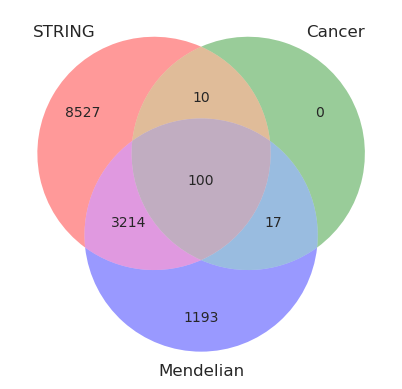

In [10]:
set1 = set(string_unips)
set2 = set(cancer_genes)
set3 = set(omim_genes)

venn3_unweighted([set1, set2, set3], ('STRING', 'Cancer', 'Mendelian'))
plt.show()

### Compute network centrality features

#### Create a graph

In [11]:
# The following is the size of the STRING PPI network when using UniProt IDs
G = nx.Graph()
G.add_edges_from(string_df.values)
print(len(G.nodes()))
print(len(G.edges()))
prots = list(G.nodes())

11851
84024


In [12]:
print(len(cancer_genes), len(omim_genes), len(prots))

127 4524 11851


#### Compute degree centrality

In [13]:
degree_dict = nx.degree_centrality(G)

In [14]:
degree_df = get_degree_centrality(prots, degree_dict)
degree_df.head()

,unip,degree,type
0,Q92793,211.0,Cancer\ndriver
1,Q13315,42.0,Cancer\ndriver
2,P43246,61.0,Cancer\ndriver
3,P52701,27.0,Cancer\ndriver
4,O75376,74.0,Cancer\ndriver


In [15]:
degree_df.to_csv('out/string_degree.txt',sep='\t',index=False)

#### Compute betweenness centrality

In [16]:
# takes about 11-12 mins
between_dict = nx.betweenness_centrality(G)

In [17]:
between_df = get_centrality(prots, between_dict)
between_df.head()

,unip,degree,type
0,Q92793,0.016290,Cancer\ndriver
1,Q13315,0.000509,Cancer\ndriver
2,P43246,0.001487,Cancer\ndriver
3,P52701,0.000232,Cancer\ndriver
4,O75376,0.002120,Cancer\ndriver


In [18]:
between_df.to_csv('out/string_betweenness.txt',sep='\t',index=False)

#### Compute closeness centrality

In [19]:
# takes about 3-4 mins
close_dict = nx.closeness_centrality(G)

In [20]:
close_df = get_centrality(prots, close_dict)
close_df.head()

,unip,degree,type
0,Q92793,0.308803,Cancer\ndriver
1,Q13315,0.272794,Cancer\ndriver
2,P43246,0.278392,Cancer\ndriver
3,P52701,0.270482,Cancer\ndriver
4,O75376,0.283476,Cancer\ndriver


In [21]:
close_df.to_csv('out/string_closeness.txt',sep='\t',index=False)

#### Compute eigenvector centrality

In [22]:
eigen_dict = nx.eigenvector_centrality(G,max_iter=1000)

In [23]:
eigen_df = get_centrality(prots, eigen_dict)
eigen_df.head()

,unip,degree,type
0,Q92793,0.000639,Cancer\ndriver
1,Q13315,0.000147,Cancer\ndriver
2,P43246,0.000433,Cancer\ndriver
3,P52701,0.000189,Cancer\ndriver
4,O75376,0.000227,Cancer\ndriver


In [24]:
eigen_df.to_csv('out/string_eigenvector.txt',sep='\t',index=False)

### Figure 2

In [25]:
mpl.rc('figure', titlesize=10)
mpl.rc('axes', labelsize=11)
mpl.rc('xtick', labelsize=9)
mpl.rc('ytick', labelsize=9)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Mendelian
disease v.s. Other: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.110e-17 U_stat=1.556e+07
Cancer
driver v.s. Mendelian
disease: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.931e-28 U_stat=2.958e+05
Cancer
driver v.s. Other: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.652e-34 U_stat=7.845e+05
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Mendelian
disease v.s. Other: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.050e-40 U_stat=1.636e+07
Cancer
driver v.s. Mendelian
disease: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.198e-25 U_stat=2.892e+05
Cancer
driver v.s. O

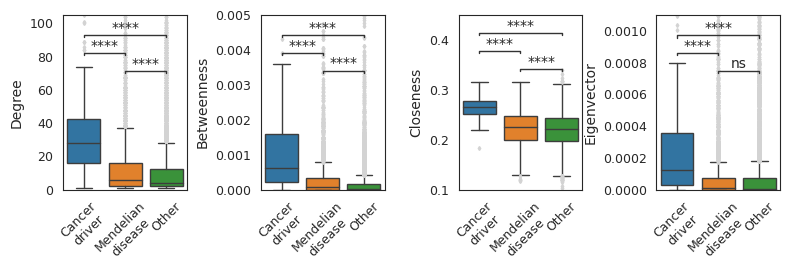

In [26]:
x = "type"
y = "degree"
order = ['Cancer\ndriver', 'Mendelian\ndisease', 'Other']
flierprops = dict(markerfacecolor = 'lightgrey', markeredgecolor='lightgrey', markersize = 2)

fig = plt.figure(figsize=(8, 2.85))

plt.subplot(1, 4, 1)
df = degree_df.copy()
ax1 = sns.boxplot(x=x, y=y, order=order, data=df, flierprops=flierprops, linewidth=1)
plt.xlabel('')
plt.ylabel('Degree')
plt.xticks(rotation=45)
plt.ylim(0,65)
add_stat_annotation(ax1, data=df, x=x, y=y, order=order,
                    box_pairs=[("Cancer\ndriver", "Other"), ("Mendelian\ndisease", "Other"),
                              ("Cancer\ndriver", "Mendelian\ndisease")],
                    test='Mann-Whitney',
                    text_format='star', loc='outside', verbose=2, linewidth=1,
                    line_offset=0.08, text_offset=0.1)
plt.ylim(0,105)

plt.subplot(1, 4, 2)
df = between_df.copy()
ax2 = sns.boxplot(x=x, y=y, order=order, data=df, flierprops=flierprops, linewidth=1)
plt.xlabel('')
plt.ylabel('Betweenness')
plt.xticks(rotation=45)
plt.ylim(0,0.0031)
add_stat_annotation(ax2, data=df, x=x, y=y, order=order,
                    box_pairs=[("Cancer\ndriver", "Other"), ("Mendelian\ndisease", "Other"),
                              ("Cancer\ndriver", "Mendelian\ndisease")],
                    test='Mann-Whitney',
                    text_format='star', loc='outside', verbose=2, linewidth=1,
                    line_offset=0.08, text_offset=0.1)
plt.ylim(0,0.005)

plt.subplot(1, 4, 3)
df = close_df.copy()
ax3 = sns.boxplot(x=x, y=y, order=order, data=df, flierprops=flierprops, linewidth=1)
plt.xlabel('')
plt.ylabel('Closeness')
plt.xticks(rotation=45)
plt.ylim(0.1,0.32)
add_stat_annotation(ax3, data=df, x=x, y=y, order=order,
                    box_pairs=[("Cancer\ndriver", "Other"), ("Mendelian\ndisease", "Other"),
                              ("Cancer\ndriver", "Mendelian\ndisease")],
                    test='Mann-Whitney',
                    text_format='star', loc='outside', verbose=2, linewidth=1,
                    line_offset=0.08, text_offset=0.1)
plt.ylim(0.1,0.45)

plt.subplot(1, 4, 4)
df = eigen_df.copy()
ax4 = sns.boxplot(x=x, y=y, order=order, data=df, flierprops=flierprops, linewidth=1)
plt.xlabel('')
plt.ylabel('Eigenvector')
plt.xticks(rotation=45)
plt.ylim(0,0.00068)
add_stat_annotation(ax4, data=df, x=x, y=y, order=order,
                    box_pairs=[("Cancer\ndriver", "Other"), ("Mendelian\ndisease", "Other"),
                              ("Cancer\ndriver", "Mendelian\ndisease")],
                    test='Mann-Whitney',
                    text_format='star', loc='outside', verbose=2, linewidth=1,
                    line_offset=0.08, text_offset=0.1)
plt.ylim(0,0.0011)

fig.tight_layout()
fig.subplots_adjust(wspace=.6)
plt.savefig('out/Fig2.pdf', transparent=True)
plt.show()